# A simple neural network to recognize hand written digits, implemented from scratch

#### @author : Vishwa007
#### @date : 01-05-2020

## Loading the dataset

In [1]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X.shape, train_y.shape

Using TensorFlow backend.


((60000, 28, 28), (60000,))

## Visualizing dataset (first 25 images of the training set)

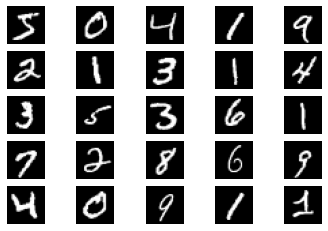

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5)
cmap = plt.get_cmap('gray')
index = 0

for i in range(5): 
    for j in range(5):
        axes[i, j].axis('off')
        axes[i, j].imshow(train_X[index], cmap=cmap)
        index += 1

plt.show()

## Data preprocessing

In [3]:
from sklearn.preprocessing import LabelBinarizer

def preprocess_data(X, y=None):
    X = np.array([x.flatten() for x in X])

    if y is not None:
        y = LabelBinarizer().fit_transform(y)
        return X, y

    return X

## Defining the model

In [4]:
import numpy as np

In [5]:
# using the sigmoid function as an activation function

def activate(z):
    return 1 / (1 + np.exp(-z))

def activation_gradient(z):
    activation = activate(z)
    return activation * (1 - activation)

In [6]:
def feed_forward(weights, X):
    length = len(weights)

    # set up initial activation matrix equal to the input matrix
    A = [X]

    # set up initial activation value matrix
    Z = []

    for i in range(length):
        # add intercept term:
        rows, cols = A[i].shape
        Ai = np.ones((rows, cols+1))
        Ai[:, 1:] = A[i]
        A[i] = Ai

        # calculate activation value Z(i) = A(i)Θ(i)'
        Z.append(A[i].dot(weights[i].transpose()))

        # append the activation in the activation matrix
        A.append(activate(Z[i]))

    # return activation matrix and activation value matrix
    return A, Z 

In [7]:
def back_propogate(weights, X, y):
    A, Z = feed_forward(weights, X)

    length = len(A) - 1
    delta = [None] * length

    delta[-1] = A[-1] - y

    for i in range(length-2, -1, -1):
        Z_grad = np.ones(A[i+1].shape)
        Z_grad[:, 1:] = activation_gradient(Z[i])

        delta[i] = (delta[i+1].dot(weights[i+1])) * Z_grad
        delta[i] = delta[i][:, 1:]

    return delta, A 

In [8]:
def cost_function(weights, X, y, reg_param):
    A, Z =  feed_forward(weights, X)

    h = A[-1]
    m = X.shape[0]

    cost = np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h)) / m
    reg_val = [np.sum(w[:, 1:]**2) for w in weights]

    cost += (reg_param / (2 * m)) * np.sum(reg_val)

    return cost

In [9]:
def gradient(weights, X, y, reg_param):
    delta, A = back_propogate(weights, X, y)

    m = X.shape[0]

    length = len(weights)
    gradients = []
    for i in range(length):
        gradient_i = (delta[i].transpose().dot(A[i])) / m 
        gradient_i[:, 1:] += (reg_param / m) * weights[i][:, 1:]
        gradients.append(gradient_i)

    return gradients

## Setting up the model

In [10]:
# function to generate random weights

def gen_init_weights(layer_units, interval):
    length = len(layer_units) - 1
    weights = []

    for i in range(1, length + 1):
        weights.append((interval[1] - interval[0]) * np.random.random_sample((layer_units[i], layer_units[i-1] + 1)) + interval[0])

    return weights 

In [11]:
# preprocess data
X, y = preprocess_data(train_X, train_y)

# define layers

input_units = X.shape[1]
output_units = y.shape[1]
hidden1 = 512
hidden2 = 512

layer_units = [input_units, hidden1, hidden2, output_units]

# define initial weights
interval = (-0.05, 0.05)
init_weights = gen_init_weights(layer_units, interval)

## Training the model

In [12]:
# Use Gradient Descent to get the optimized weights

def gradientDescent(weights, X, y, learning_rate, reg_param, iterations):
    m = y.shape[1]

    length = len(weights)
    
    progress = 0
    
    unit = int(iterations * 0.05)
    unit = 1 if unit < 1 else unit

    for itr in range(iterations):
        if (itr + 1) % unit == 0:
            progress += 1

        elif itr == iterations-1:
            progress = 20
            
        percent = progress * 5
        bar = '##' * progress
        rem = ' ' * (40 - (progress * 2))
        msg = f'Iteration : {itr + 1}    Progress ({progress * 5} %)  |' + bar + rem + '|\r'
        print(msg, end='')

        grad = gradient(weights, X, y, reg_param)
        for i in range(length):
            weights[i] -= (learning_rate * grad[i])
            
    print()
    return weights

In [13]:
# initial cost
print(f'Initial cost : {cost_function(init_weights, X, y, reg_param=1)}')

Initial cost : 6.6633763484218775


In [14]:
weights = gradientDescent(init_weights, X, y, learning_rate=0.1, reg_param=1, iterations=500)

# cost after optimization
print(f'Optimized cost : {cost_function(weights, X, y, reg_param=1)}')

Iteration : 500    Progress (100 %)  |########################################|
Optimized cost : 0.5083928348101422


## Testing the model

In [15]:
# train accuracy

A, Z = feed_forward(weights, X)
output = np.argmax(A[-1], axis=1)

np.mean(train_y == output) * 100

93.10333333333334

In [16]:
# test accuracy

A, Z = feed_forward(weights, preprocess_data(test_X))
output = np.argmax(A[-1], axis=1)

np.mean(test_y == output) * 100

92.15